#### Importing Libraries

In [441]:
import pandas as pd
import geopandas
import numpy as np
import shapely
import shapefile
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
import chart_studio.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

## Choropleth - Population by County

### Preparing Data

In [442]:
df = pd.read_csv("cleaned_df.csv")
df.dtypes
df = df.dropna()
df.columns

Index(['name', 'num_stores', 'county', 'land_area', 'FIPS', 'Total.Pop',
       'Household', 'Group.Quarters', 'Total.HU', 'Single.Detached',
       'Single.Attached', 'Two.to.Four', 'Five.Plus', 'Mobile.Homes',
       'Occupied', 'Vacancy.Rate', 'Persons.per.Household'],
      dtype='object')

In [443]:
# convert data types
df.loc[:,['name','county','FIPS']] = df.astype(str)

for i in range(5,17):
    df.iloc[:,i] = df.iloc[:,i].astype(str).str.replace(",|%","")
    df.iloc[:,i] = df.iloc[:,i].astype(float)
    
#convert percents too decimals
df['Vacancy.Rate'] = df['Vacancy.Rate'].astype(str).replace("\.","")
df['Vacancy.Rate'] = df['Vacancy.Rate'].astype(float)/100

# Find mean instead of total for Vacancy Rate and Persons per Household
df_county = df.groupby(['county']).agg('sum')
df_county[['Vacancy.Rate','Persons.per.Household']] = df.groupby("county").agg("mean")[['Vacancy.Rate','Persons.per.Household']]

In [444]:
df_county = df_county.reset_index()
df_county
#land area is sum of all cities with Trader Joe's so will need to find the overall land area

,county,num_stores,land_area,Total.Pop,Household,Group.Quarters,Total.HU,Single.Detached,Single.Attached,Two.to.Four,Five.Plus,Mobile.Homes,Occupied,Vacancy.Rate,Persons.per.Household
0,Alameda,8,204.86,1055432.0,1029086.0,26346.0,406036.0,194462.0,29019.0,55458.0,124513.0,2584.0,383977.0,0.054857,2.584286
1,Butte,1,32.92,110326.0,106605.0,3721.0,41738.0,22365.0,1648.0,6345.0,9302.0,2078.0,39650.0,0.050000,2.690000
2,Contra Costa,9,125.42,463177.0,460051.0,3126.0,176024.0,109408.0,16199.0,12138.0,35995.0,2284.0,167947.0,0.046875,2.741250
3,Fresno,2,135.24,664944.0,654806.0,10138.0,224554.0,143588.0,5413.0,25866.0,43970.0,5717.0,213032.0,0.046000,3.010000
4,Kern,1,142.16,392756.0,389102.0,3654.0,131363.0,94257.0,3361.0,14677.0,16289.0,2779.0,123160.0,0.062000,3.160000
5,Los Angeles,42,894.37,6025463.0,5900529.0,124934.0,2311470.0,941322.0,139265.0,204734.0,1004608.0,21541.0,2155177.0,0.054818,2.605909
6,Marin,2,43.91,113509.0,110730.0,2779.0,45591.0,23715.0,5844.0,3457.0,11620.0,955.0,43760.0,0.040500,2.535000
7,Monterey,2,11.33,43435.0,40547.0,2888.0,21906.0,10652.0,1334.0,3747.0,5973.0,200.0,18760.0,0.149500,2.170000
8,Napa,1,17.84,79278.0,78032.0,1246.0,30698.0,19031.0,2181.0,2957.0,5164.0,1365.0,28655.0,0.067000,2.720000
9,Orange,21,326.89,1807522.0,1772115.0,35407.0,643718.0,314363.0,83334.0,55935.0,172810.0,17276.0,609505.0,0.050471,2.864118


In [445]:
df_size = pd.read_csv("county_size.csv", header=None)

In [446]:
#change strings to floats
df_size.columns = ['county','size']
df_size['size'] = df_size['size'].apply(lambda x: x.split(" ")[0])
df_size['size'] = df_size['size'].apply(lambda x: x.replace(',',''))
df_size['size'] = df_size['size'].astype(float)

#get rid of "County" for joining dataframes
df_size['county'] = df_size['county'].apply(lambda x: x.replace(" County",""))

# join df_size with df_county
df_county = pd.merge(df_county,df_size,how='left',on='county')

In [447]:
df_county = df_county.drop(columns=['land_area'])
df_county

,county,num_stores,Total.Pop,Household,Group.Quarters,Total.HU,Single.Detached,Single.Attached,Two.to.Four,Five.Plus,Mobile.Homes,Occupied,Vacancy.Rate,Persons.per.Household,size
0,Alameda,8,1055432.0,1029086.0,26346.0,406036.0,194462.0,29019.0,55458.0,124513.0,2584.0,383977.0,0.054857,2.584286,738.0
1,Butte,1,110326.0,106605.0,3721.0,41738.0,22365.0,1648.0,6345.0,9302.0,2078.0,39650.0,0.050000,2.690000,1640.0
2,Contra Costa,9,463177.0,460051.0,3126.0,176024.0,109408.0,16199.0,12138.0,35995.0,2284.0,167947.0,0.046875,2.741250,720.0
3,Fresno,2,664944.0,654806.0,10138.0,224554.0,143588.0,5413.0,25866.0,43970.0,5717.0,213032.0,0.046000,3.010000,5963.0
4,Kern,1,392756.0,389102.0,3654.0,131363.0,94257.0,3361.0,14677.0,16289.0,2779.0,123160.0,0.062000,3.160000,8142.0
5,Los Angeles,42,6025463.0,5900529.0,124934.0,2311470.0,941322.0,139265.0,204734.0,1004608.0,21541.0,2155177.0,0.054818,2.605909,4060.0
6,Marin,2,113509.0,110730.0,2779.0,45591.0,23715.0,5844.0,3457.0,11620.0,955.0,43760.0,0.040500,2.535000,520.0
7,Monterey,2,43435.0,40547.0,2888.0,21906.0,10652.0,1334.0,3747.0,5973.0,200.0,18760.0,0.149500,2.170000,3322.0
8,Napa,1,79278.0,78032.0,1246.0,30698.0,19031.0,2181.0,2957.0,5164.0,1365.0,28655.0,0.067000,2.720000,754.0
9,Orange,21,1807522.0,1772115.0,35407.0,643718.0,314363.0,83334.0,55935.0,172810.0,17276.0,609505.0,0.050471,2.864118,948.0


### Exploring Population

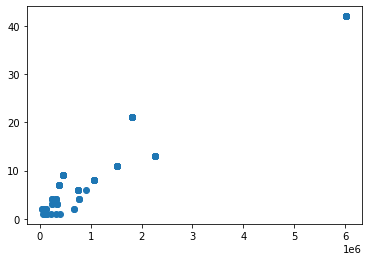

In [90]:
plt.scatter(df_county['Total.Pop'],df_county['num_stores'])

There seems to be a positive correlation between population and number of stores in a county.

In [91]:
# creating choropleth
values = df_county['Total.Pop'].tolist()
fips = df_county['FIPS'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values, scope=['CA'],
    binning_endpoints=[14348, 63983, 134827, 426762, 2081313],
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=False,
    legend_title='Population by County', title='California',
        state_outline={'width': 1},
)

iplot(fig, filename='Choropleth Map Creation')


## Choropleth - Population Density by County in California

### Preparing Data

In [107]:
df_county = pd.merge(df.groupby(['county']).agg('sum').drop(columns='Persons.per.Household'),df[['county','FIPS']],how='left',on='county')
df_county['Pop.Density'] = df_county['Total.Pop']/df_county['land_area']
df_county['Pop.Density']

0      5151.967197
1      5151.967197
2      5151.967197
3      5151.967197
4      5151.967197
          ...     
110    6030.241389
111    2773.698725
112    2773.698725
113    2773.698725
114    6995.247725
Name: Pop.Density, Length: 115, dtype: float64

In [95]:
df_county['Pop.Density.Normalized'] = (df_county['Pop.Density']-np.mean(df_county['Pop.Density']))/np.std(df_county['Pop.Density'])

### Exploring Population Density

{'whiskers': [<matplotlib.lines.Line2D at 0x1324e9350>,
 'caps': [<matplotlib.lines.Line2D at 0x130ee1410>,
 'boxes': [<matplotlib.lines.Line2D at 0x131a96d10>],
 'medians': [<matplotlib.lines.Line2D at 0x1312c9550>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f79d890>],
 'means': []}

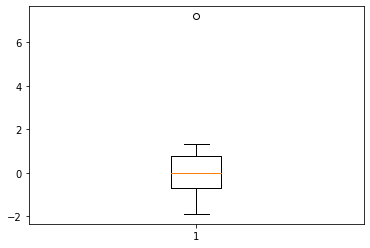

In [96]:
plt.boxplot(df_county['Pop.Density.Normalized']) #normalization makes comparison easier

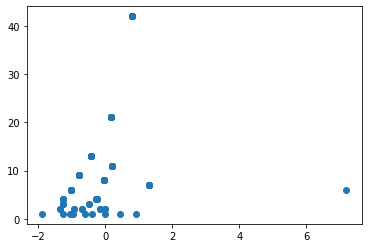

In [97]:
plt.scatter(df_total_pop_county['Pop.Density.Normalized'],df_total_pop_county['num_stores'])

There seems to be a positive correlation between population density and number of store in a county.

In [98]:
df.columns

Index(['name', 'num_stores', 'county', 'land_area', 'FIPS', 'Total.Pop',
       'Household', 'Group.Quarters', 'Total.HU', 'Single.Detached',
       'Single.Attached', 'Two.to.Four', 'Five.Plus', 'Mobile.Homes',
       'Occupied', 'Vacancy.Rate', 'Persons.per.Household'],
      dtype='object')

### Scatter Plots for Other Variables against Number of Stores

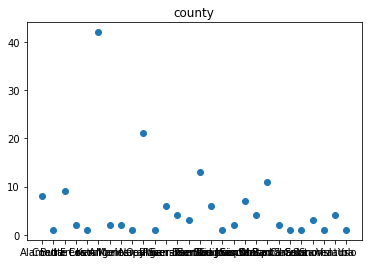

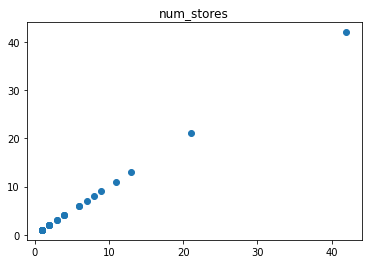

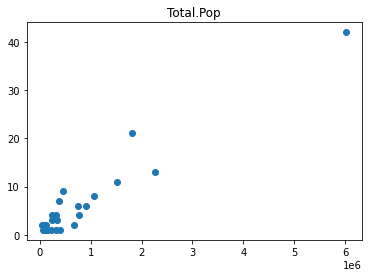

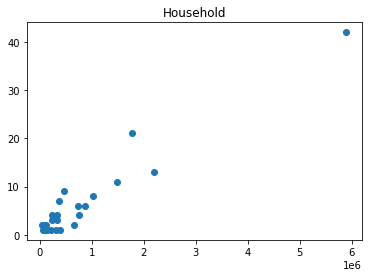

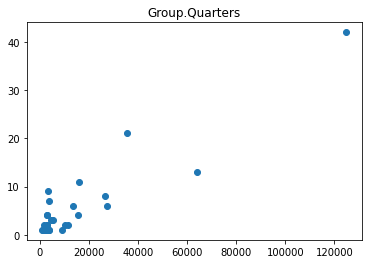

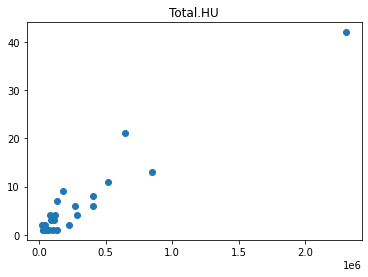

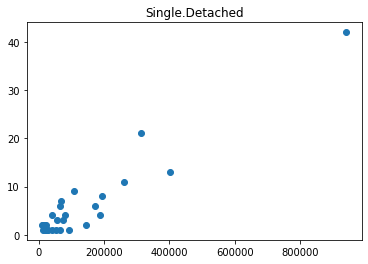

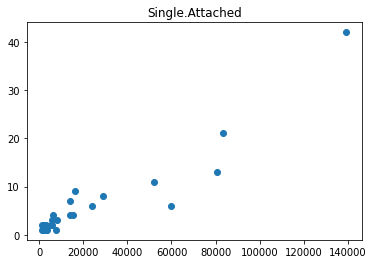

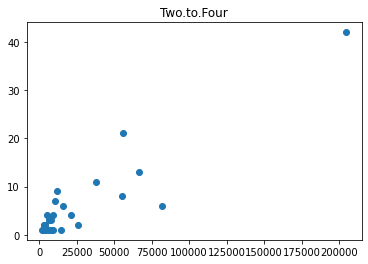

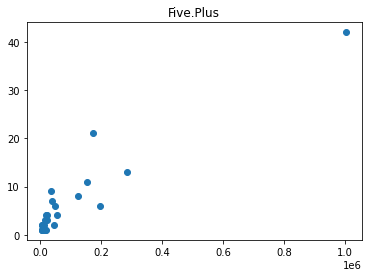

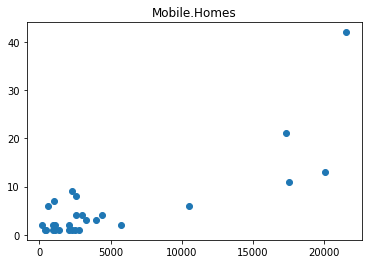

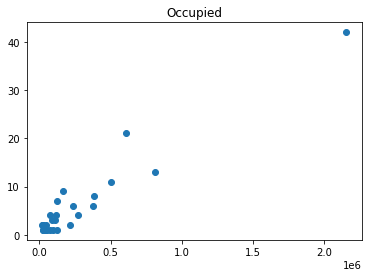

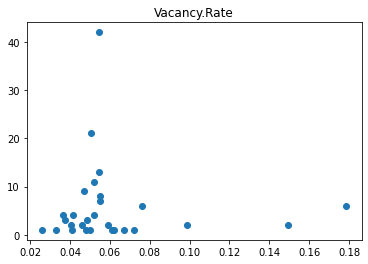

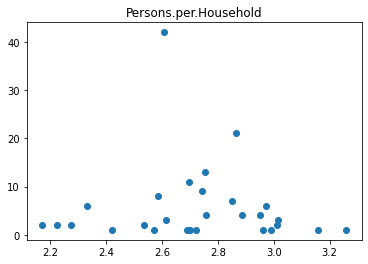

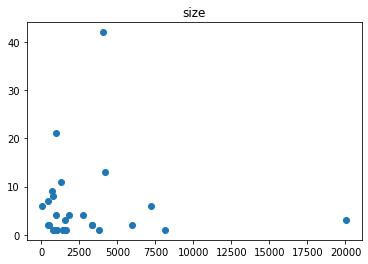

In [451]:
for i in range(0,len(df_county.columns)):
    plt.scatter(y=df_county['num_stores'], x=df_county.iloc[:,i])
    plt.title(df_county.columns[i])
    plt.show()